# Test Runs:
Just checking if APIs are working

In [1]:
%pip install --upgrade --quiet  langchain-core langchain-community langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [5]:
# import os
# from dotenv import load_dotenv

# # Load environment variables from .env file
# load_dotenv()

# # Retrieve the API key from environment variables
# api_key = os.getenv("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-3.5-turbo", )

In [6]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")
output_parser = StrOutputParser()

chain = prompt | model | output_parser

chain.invoke({"topic": "ice cream"})

'Why did the ice cream truck break down?\n\nBecause it had too many "scoops"!'

# Math Agent using LCEL:

In [1]:
from langchain_core.tools import tool


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

@tool
def divide(a: int, b: int) -> int:
    """Divide two numbers."""
    return a / b

@tool
def sum(a: int, b: int) -> int:
    """Sum two numbers."""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers."""
    return a - b

# Compile tools into a list
math_tools = [multiply, divide, sum, subtract]


print(subtract.name)
print(subtract.description)
print(subtract.args)

subtract
Subtract two numbers.
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}


In [10]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0,)
llm_with_tools = llm.bind_tools(math_tools)

In [15]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are very powerful assistant and you respond to the user in a friendly manner.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

In [16]:
from langchain.agents.format_scratchpad.openai_tools import format_to_openai_tool_messages
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

In [17]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=math_tools, verbose=True)

In [20]:
list(agent_executor.stream({"input": "subtract 5 from 9 and then add 1 to the result"}))





> Entering new AgentExecutor chain...

Invoking: `subtract` with `{'a': 9, 'b': 5}`


4
Invoking: `sum` with `{'a': 4, 'b': 1}`


5Subtracting 5 from 9 gives us 4. Adding 1 to 4 results in 5.

> Finished chain.


[{'actions': [ToolAgentAction(tool='subtract', tool_input={'a': 9, 'b': 5}, log="\nInvoking: `subtract` with `{'a': 9, 'b': 5}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_X93nxISTLrffxvxDN5agMr3q', 'function': {'arguments': '{"a": 9, "b": 5}', 'name': 'subtract'}, 'type': 'function'}, {'index': 1, 'id': 'call_hb5POJk2ahInfMKQZqop2Qlj', 'function': {'arguments': '{"a": 4, "b": 1}', 'name': 'sum'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-ec72c4c4-4466-4d07-a40d-cca583211e50', tool_calls=[{'name': 'subtract', 'args': {'a': 9, 'b': 5}, 'id': 'call_X93nxISTLrffxvxDN5agMr3q'}, {'name': 'sum', 'args': {'a': 4, 'b': 1}, 'id': 'call_hb5POJk2ahInfMKQZqop2Qlj'}], tool_call_chunks=[{'name': 'subtract', 'args': '{"a": 9, "b": 5}', 'id': 'call_X93nxISTLrffxvxDN5agMr3q', 'index': 0}, {'name': 'sum', 'args': '{"a": 4, "b": 1}', 'id': 'call_hb5POJk2ahInfMKQZqop2Q

In [29]:
agent_executor.invoke({'input':'add 4 and 5 then subtract 1 from the result'})



> Entering new AgentExecutor chain...

Invoking: `sum` with `{'a': 4, 'b': 5}`


9
Invoking: `subtract` with `{'a': 9, 'b': 1}`


8The sum of 4 and 5 is 9. If we subtract 1 from 9, the result is 8.

> Finished chain.


{'input': 'add 4 and 5 then subtract 1 from the result',
 'output': 'The sum of 4 and 5 is 9. If we subtract 1 from 9, the result is 8.'}

# LangGraph

In [31]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=3)

In [4]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [5]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Match calculation agent and node
math_agent = create_agent(
    llm,
    math_tools,
    system_message="Only run this is match calculation is demanded else ignore and move to Researcher.",
)
math_node = functools.partial(agent_node, agent=math_agent, name="MathCalculator")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate answer to the use based on the query asked.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [6]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, multiply, divide, sum, subtract]
tool_node = ToolNode(tools)

In [7]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [8]:
workflow = StateGraph(AgentState)
workflow.add_node("MathCalculator", math_node)
workflow.add_node("Researcher", research_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    'MathCalculator',
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": END, "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "MathCalculator": "MathCalculator",
    },
)
workflow.set_entry_point("MathCalculator")
graph = workflow.compile()

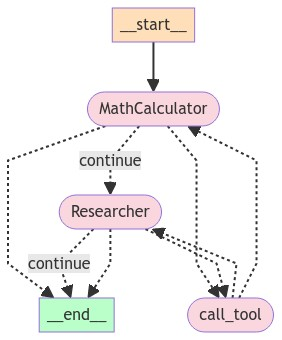

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Search for 'langchain usecase' and once you find the answer show to user then, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'MathCalculator': {'messages': [AIMessage(content="I don't have the ability to browse the internet in real-time. However, I can provide information based on existing knowledge or tools available to me. Would you like me to proceed with that approach?", response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 250, 'total_tokens': 291}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='MathCalculator', id='run-c16ee665-aa36-400c-9a90-445a5dc2c13c-0', usage_metadata={'input_tokens': 250, 'output_tokens': 41, 'total_tokens': 291})], 'sender': 'MathCalculator'}}
----
{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xibRkWwAiqAd5s94Wbz82Hjm', 'function': {'arguments': '{"query":"langchain usecase"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 263, 'total_tokens': 28